Exercise 3_2:
-------

Consider a binomial modell with $S_0=100$ and zero interest rate, i.e. $r=0$ for two periods with $u=1.2$ and $d=0.9$ under the risk neutral measure $Q$. Compute the price $x$ of a European call option with strike $K=100$. Determine the Hedging strategy $(H_1,H_2)$, i.e. the predictable process $H=(H_1,H_2)$ such that

$$
(S_2-K)^+=x+H_1(S_1-S_0)+H_2(S_2-S_1)=x +(H \bullet S)_2
$$

first analytically and second by the following approach. For $i=1,2$, let $H_i$ be a function of $S_{i-1}$, i.e. $H_i=g(S_{i-1})$ and  parametrize $g$ as neural network with parameters $\theta$.
Try to find $g$ via

$$
\min_{\theta}\mathbb{E}_{\mathbb{Q}}[((S_2-K)^+-x -(g(S_{\cdot-1}| \theta) \bullet S_{\cdot})_2)^2].
$$

Is it possible to come close to the analytical solution?

The following code solves the numerical part of the above exercise

In [85]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [86]:
# Importing the required Keras modules containing model and layers
from keras.models import Sequential
from keras.layers import Input, Dense, Conv2D, Concatenate, Dropout, Subtract, \
                        Flatten, MaxPooling2D, Multiply, Lambda, Add, Dot
from keras.backend import constant
from keras import optimizers
from keras import regularizers

from keras.engine.topology import Layer
from keras.models import Model
from keras.layers import Input
from keras import initializers
from keras.constraints import max_norm
import keras.backend as K

In [87]:
  
N=2 # Time steps   
d=2 #number of layers for each of the neural networks
n=32 #number of nodes except in the last layer

# architecture is the same for all networks
layers = []
for j in range(N):
    for i in range(d):
        if i < d-1:
            nodes = n
            layer = Dense(n, activation='tanh',trainable=True,
                      kernel_initializer=initializers.RandomNormal(0,1),#kernel_initializer='random_normal',
                      bias_initializer='random_normal',
                      name=str(i)+str(j))
        else:
            nodes = 1
            layer = Dense(nodes, activation='linear', trainable=True,
                          kernel_initializer=initializers.RandomNormal(0,0.1),#kernel_initializer='random_normal',
                          bias_initializer='random_normal',
                          name=str(i)+str(j))
        layers = layers + [layer]
        

In [88]:
price = Input(shape=(1,))
hedge = Input(shape=(1,)) 
inputs = [price] + [hedge]


for j in range(N): 
    strategyhelper = price
    for k in range(d):
        strategyhelper = layers[k+(j)*d](strategyhelper)# hedging strategy g_j, j=1,2
    multincrement = Input(shape=(1,)) # price increment u or d   
    pricenew = Multiply()([price,multincrement])
    priceincrement=Subtract()([pricenew, price])
    hedgenew=Multiply()([strategyhelper, priceincrement])
    hedge=Add()([hedge,hedgenew])
    inputs = inputs + [multincrement]
    price = pricenew
payoff= Lambda(lambda x : 0.5*(K.abs(x-100)+x-100) -76/9 )(price) #76/9 is the true price
outputs= Subtract()([payoff,hedge]) # payoff minus price minus hedge 
        

inputs = inputs
outputs= outputs


hedging_train= Model(inputs=inputs, outputs=outputs)

In [89]:
hedging_train.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_32 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
input_34 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
multiply_35 (Multiply)          (None, 1)            0           input_32[0][0]                   
                                                                 input_34[0][0]                   
__________________________________________________________________________________________________
input_35 (InputLayer)           (None, 1)            0                                            
__________

In [90]:
# Generation of training data


Ltrain = 10**3
        
        
xtrain=([100*np.ones(Ltrain)]+ [0.0*np.ones(Ltrain)]+[0.3*np.random.binomial(1, 1/3, Ltrain)+0.9 for i in range(N)])
ytrain=([np.zeros(Ltrain)])

In [92]:
hedging_train.compile(optimizer='adam', 
              loss='mean_squared_error')

for i in range(1):
    hedging_train.fit(x=xtrain,y=ytrain,epochs=3000,verbose=True,batch_size=10**3)
 
    

Epoch 1/3000
1000/1000 [==============================] - 0s 280us/step - loss: 8.1628e-06
Epoch 2/3000
1000/1000 [==============================] - 0s 2us/step - loss: 5.6974
Epoch 3/3000
1000/1000 [==============================] - 0s 2us/step - loss: 0.3862
Epoch 4/3000
1000/1000 [==============================] - 0s 2us/step - loss: 0.9773
Epoch 5/3000
1000/1000 [==============================] - 0s 2us/step - loss: 3.1532
Epoch 6/3000
1000/1000 [==============================] - 0s 2us/step - loss: 2.3182
Epoch 7/3000
1000/1000 [==============================] - 0s 2us/step - loss: 0.5653
Epoch 8/3000
1000/1000 [==============================] - 0s 3us/step - loss: 0.0212
Epoch 9/3000
1000/1000 [==============================] - 0s 3us/step - loss: 0.7821
Epoch 10/3000
1000/1000 [==============================] - 0s 3us/step - loss: 1.5385
Epoch 11/3000
1000/1000 [==============================] - 0s 3us/step - loss: 1.4058
Epoch 12/3000
1000/1000 [==============================] 

Epoch 96/3000
1000/1000 [==============================] - 0s 6us/step - loss: 3.1064e-04
Epoch 97/3000
1000/1000 [==============================] - 0s 8us/step - loss: 1.6256e-04
Epoch 98/3000
1000/1000 [==============================] - 0s 3us/step - loss: 2.4806e-04
Epoch 99/3000
1000/1000 [==============================] - 0s 3us/step - loss: 3.4672e-04
Epoch 100/3000
1000/1000 [==============================] - 0s 3us/step - loss: 2.5761e-04
Epoch 101/3000
1000/1000 [==============================] - 0s 3us/step - loss: 1.3617e-04
Epoch 102/3000
1000/1000 [==============================] - 0s 3us/step - loss: 1.6771e-04
Epoch 103/3000
1000/1000 [==============================] - 0s 3us/step - loss: 2.4521e-04
Epoch 104/3000
1000/1000 [==============================] - 0s 3us/step - loss: 2.0265e-04
Epoch 105/3000
1000/1000 [==============================] - 0s 4us/step - loss: 1.1329e-04
Epoch 106/3000
1000/1000 [==============================] - 0s 5us/step - loss: 1.1985e-04
Epo

1000/1000 [==============================] - 0s 4us/step - loss: 1.9667e-07
Epoch 187/3000
1000/1000 [==============================] - 0s 2us/step - loss: 1.6392e-07
Epoch 188/3000
1000/1000 [==============================] - 0s 3us/step - loss: 1.3881e-07
Epoch 189/3000
1000/1000 [==============================] - 0s 4us/step - loss: 1.3825e-07
Epoch 190/3000
1000/1000 [==============================] - 0s 3us/step - loss: 1.2539e-07
Epoch 191/3000
1000/1000 [==============================] - 0s 3us/step - loss: 1.0092e-07
Epoch 192/3000
1000/1000 [==============================] - 0s 3us/step - loss: 9.4387e-08
Epoch 193/3000
1000/1000 [==============================] - 0s 3us/step - loss: 9.0290e-08
Epoch 194/3000
1000/1000 [==============================] - 0s 3us/step - loss: 7.4464e-08
Epoch 195/3000
1000/1000 [==============================] - 0s 3us/step - loss: 6.3199e-08
Epoch 196/3000
1000/1000 [==============================] - 0s 3us/step - loss: 6.2727e-08
Epoch 197/3000

Epoch 277/3000
1000/1000 [==============================] - 0s 5us/step - loss: 2.3831e-11
Epoch 278/3000
1000/1000 [==============================] - 0s 3us/step - loss: 2.3831e-11
Epoch 279/3000
1000/1000 [==============================] - 0s 3us/step - loss: 8.7996e-12
Epoch 280/3000
1000/1000 [==============================] - 0s 4us/step - loss: 8.7996e-12
Epoch 281/3000
1000/1000 [==============================] - 0s 3us/step - loss: 8.7996e-12
Epoch 282/3000
1000/1000 [==============================] - 0s 3us/step - loss: 1.0405e-11
Epoch 283/3000
1000/1000 [==============================] - 0s 3us/step - loss: 1.0405e-11
Epoch 284/3000
1000/1000 [==============================] - 0s 4us/step - loss: 1.0405e-11
Epoch 285/3000
1000/1000 [==============================] - 0s 3us/step - loss: 8.7996e-12
Epoch 286/3000
1000/1000 [==============================] - 0s 3us/step - loss: 1.1443e-11
Epoch 287/3000
1000/1000 [==============================] - 0s 3us/step - loss: 1.4030e-11

1000/1000 [==============================] - 0s 3us/step - loss: 2.7851e-11
Epoch 368/3000
1000/1000 [==============================] - 0s 4us/step - loss: 1.1129e-11
Epoch 369/3000
1000/1000 [==============================] - 0s 3us/step - loss: 2.1730e-11
Epoch 370/3000
1000/1000 [==============================] - 0s 3us/step - loss: 2.1730e-11
Epoch 371/3000
1000/1000 [==============================] - 0s 4us/step - loss: 1.1129e-11
Epoch 372/3000
1000/1000 [==============================] - 0s 5us/step - loss: 2.7851e-11
Epoch 373/3000
1000/1000 [==============================] - 0s 3us/step - loss: 2.2044e-11
Epoch 374/3000
1000/1000 [==============================] - 0s 4us/step - loss: 1.1741e-11
Epoch 375/3000
1000/1000 [==============================] - 0s 4us/step - loss: 2.3655e-11
Epoch 376/3000
1000/1000 [==============================] - 0s 3us/step - loss: 2.3655e-11
Epoch 377/3000
1000/1000 [==============================] - 0s 4us/step - loss: 1.2094e-11
Epoch 378/3000

Epoch 458/3000
1000/1000 [==============================] - 0s 3us/step - loss: 2.5919e-11
Epoch 459/3000
1000/1000 [==============================] - 0s 3us/step - loss: 1.0467e-11
Epoch 460/3000
1000/1000 [==============================] - 0s 3us/step - loss: 3.3063e-11
Epoch 461/3000
1000/1000 [==============================] - 0s 3us/step - loss: 1.7573e-11
Epoch 462/3000
1000/1000 [==============================] - 0s 3us/step - loss: 1.8993e-11
Epoch 463/3000
1000/1000 [==============================] - 0s 3us/step - loss: 4.2067e-11
Epoch 464/3000
1000/1000 [==============================] - 0s 3us/step - loss: 1.4112e-11
Epoch 465/3000
1000/1000 [==============================] - 0s 3us/step - loss: 1.5223e-11
Epoch 466/3000
1000/1000 [==============================] - 0s 4us/step - loss: 1.5223e-11
Epoch 467/3000
1000/1000 [==============================] - 0s 4us/step - loss: 1.6218e-11
Epoch 468/3000
1000/1000 [==============================] - 0s 3us/step - loss: 1.4112e-11

1000/1000 [==============================] - 0s 3us/step - loss: 1.7460e-11
Epoch 549/3000
1000/1000 [==============================] - 0s 3us/step - loss: 2.3348e-11
Epoch 550/3000
1000/1000 [==============================] - 0s 3us/step - loss: 8.8621e-12
Epoch 551/3000
1000/1000 [==============================] - 0s 2us/step - loss: 2.8589e-11
Epoch 552/3000
1000/1000 [==============================] - 0s 3us/step - loss: 7.4062e-12
Epoch 553/3000
1000/1000 [==============================] - 0s 3us/step - loss: 1.7483e-11
Epoch 554/3000
1000/1000 [==============================] - 0s 3us/step - loss: 1.9630e-11
Epoch 555/3000
1000/1000 [==============================] - 0s 4us/step - loss: 1.1905e-11
Epoch 556/3000
1000/1000 [==============================] - 0s 4us/step - loss: 2.7851e-11
Epoch 557/3000
1000/1000 [==============================] - 0s 3us/step - loss: 1.3034e-11
Epoch 558/3000
1000/1000 [==============================] - 0s 3us/step - loss: 2.4572e-11
Epoch 559/3000

Epoch 639/3000
1000/1000 [==============================] - 0s 5us/step - loss: 4.2922e-11
Epoch 640/3000
1000/1000 [==============================] - 0s 3us/step - loss: 9.7998e-12
Epoch 641/3000
1000/1000 [==============================] - 0s 3us/step - loss: 1.7809e-11
Epoch 642/3000
1000/1000 [==============================] - 0s 5us/step - loss: 1.7809e-11
Epoch 643/3000
1000/1000 [==============================] - 0s 9us/step - loss: 9.7998e-12
Epoch 644/3000
1000/1000 [==============================] - 0s 4us/step - loss: 4.2922e-11
Epoch 645/3000
1000/1000 [==============================] - 0s 7us/step - loss: 9.4044e-12
Epoch 646/3000
1000/1000 [==============================] - 0s 3us/step - loss: 2.7851e-11
Epoch 647/3000
1000/1000 [==============================] - 0s 3us/step - loss: 2.2044e-11
Epoch 648/3000
1000/1000 [==============================] - 0s 6us/step - loss: 3.4658e-11
Epoch 649/3000
1000/1000 [==============================] - 0s 4us/step - loss: 3.4658e-11

1000/1000 [==============================] - 0s 3us/step - loss: 6.7187e-12
Epoch 730/3000
1000/1000 [==============================] - 0s 3us/step - loss: 7.4635e-12
Epoch 731/3000
1000/1000 [==============================] - 0s 3us/step - loss: 7.9990e-12
Epoch 732/3000
1000/1000 [==============================] - 0s 3us/step - loss: 7.9990e-12
Epoch 733/3000
1000/1000 [==============================] - 0s 3us/step - loss: 7.9990e-12
Epoch 734/3000
1000/1000 [==============================] - 0s 5us/step - loss: 7.9990e-12
Epoch 735/3000
1000/1000 [==============================] - 0s 4us/step - loss: 7.4635e-12
Epoch 736/3000
1000/1000 [==============================] - 0s 4us/step - loss: 6.7187e-12
Epoch 737/3000
1000/1000 [==============================] - 0s 5us/step - loss: 6.7187e-12
Epoch 738/3000
1000/1000 [==============================] - 0s 5us/step - loss: 7.4635e-12
Epoch 739/3000
1000/1000 [==============================] - 0s 4us/step - loss: 7.4635e-12
Epoch 740/3000

Epoch 820/3000
1000/1000 [==============================] - 0s 6us/step - loss: 6.6848e-12
Epoch 821/3000
1000/1000 [==============================] - 0s 4us/step - loss: 6.6848e-12
Epoch 822/3000
1000/1000 [==============================] - 0s 5us/step - loss: 6.6848e-12
Epoch 823/3000
1000/1000 [==============================] - 0s 6us/step - loss: 6.6848e-12
Epoch 824/3000
1000/1000 [==============================] - 0s 3us/step - loss: 6.6848e-12
Epoch 825/3000
1000/1000 [==============================] - 0s 3us/step - loss: 8.7039e-12
Epoch 826/3000
1000/1000 [==============================] - 0s 5us/step - loss: 8.7039e-12
Epoch 827/3000
1000/1000 [==============================] - 0s 4us/step - loss: 8.7039e-12
Epoch 828/3000
1000/1000 [==============================] - 0s 4us/step - loss: 6.6848e-12
Epoch 829/3000
1000/1000 [==============================] - 0s 8us/step - loss: 6.6848e-12
Epoch 830/3000
1000/1000 [==============================] - 0s 4us/step - loss: 6.6848e-12

1000/1000 [==============================] - 0s 4us/step - loss: 8.7039e-12
Epoch 911/3000
1000/1000 [==============================] - 0s 6us/step - loss: 8.7039e-12
Epoch 912/3000
1000/1000 [==============================] - 0s 4us/step - loss: 6.6848e-12
Epoch 913/3000
1000/1000 [==============================] - 0s 6us/step - loss: 6.6848e-12
Epoch 914/3000
1000/1000 [==============================] - 0s 4us/step - loss: 6.6848e-12
Epoch 915/3000
1000/1000 [==============================] - 0s 3us/step - loss: 7.4635e-12
Epoch 916/3000
1000/1000 [==============================] - 0s 5us/step - loss: 8.7039e-12
Epoch 917/3000
1000/1000 [==============================] - 0s 3us/step - loss: 6.6848e-12
Epoch 918/3000
1000/1000 [==============================] - 0s 4us/step - loss: 6.6848e-12
Epoch 919/3000
1000/1000 [==============================] - 0s 5us/step - loss: 6.6848e-12
Epoch 920/3000
1000/1000 [==============================] - 0s 4us/step - loss: 8.7039e-12
Epoch 921/3000

Epoch 1001/3000
1000/1000 [==============================] - 0s 5us/step - loss: 7.4635e-12
Epoch 1002/3000
1000/1000 [==============================] - 0s 3us/step - loss: 8.7039e-12
Epoch 1003/3000
1000/1000 [==============================] - 0s 6us/step - loss: 6.6848e-12
Epoch 1004/3000
1000/1000 [==============================] - 0s 5us/step - loss: 6.6848e-12
Epoch 1005/3000
1000/1000 [==============================] - 0s 3us/step - loss: 7.4635e-12
Epoch 1006/3000
1000/1000 [==============================] - 0s 3us/step - loss: 7.4635e-12
Epoch 1007/3000
1000/1000 [==============================] - 0s 8us/step - loss: 6.6848e-12
Epoch 1008/3000
1000/1000 [==============================] - 0s 3us/step - loss: 6.6848e-12
Epoch 1009/3000
1000/1000 [==============================] - 0s 3us/step - loss: 6.6848e-12
Epoch 1010/3000
1000/1000 [==============================] - 0s 3us/step - loss: 7.4635e-12
Epoch 1011/3000
1000/1000 [==============================] - 0s 3us/step - loss:

1000/1000 [==============================] - 0s 6us/step - loss: 6.6848e-12
Epoch 1091/3000
1000/1000 [==============================] - 0s 5us/step - loss: 7.4635e-12
Epoch 1092/3000
1000/1000 [==============================] - 0s 3us/step - loss: 7.4635e-12
Epoch 1093/3000
1000/1000 [==============================] - 0s 5us/step - loss: 7.4635e-12
Epoch 1094/3000
1000/1000 [==============================] - 0s 3us/step - loss: 6.6848e-12
Epoch 1095/3000
1000/1000 [==============================] - 0s 4us/step - loss: 6.6848e-12
Epoch 1096/3000
1000/1000 [==============================] - 0s 4us/step - loss: 6.6848e-12
Epoch 1097/3000
1000/1000 [==============================] - 0s 3us/step - loss: 8.7039e-12
Epoch 1098/3000
1000/1000 [==============================] - 0s 3us/step - loss: 8.7039e-12
Epoch 1099/3000
1000/1000 [==============================] - 0s 6us/step - loss: 6.6848e-12
Epoch 1100/3000
1000/1000 [==============================] - 0s 3us/step - loss: 6.6848e-12
Epoc

Epoch 1180/3000
1000/1000 [==============================] - 0s 5us/step - loss: 2.8244e-11
Epoch 1181/3000
1000/1000 [==============================] - 0s 5us/step - loss: 2.0677e-11
Epoch 1182/3000
1000/1000 [==============================] - 0s 4us/step - loss: 8.4849e-12
Epoch 1183/3000
1000/1000 [==============================] - 0s 3us/step - loss: 8.7039e-12
Epoch 1184/3000
1000/1000 [==============================] - 0s 6us/step - loss: 2.1231e-11
Epoch 1185/3000
1000/1000 [==============================] - 0s 4us/step - loss: 1.7971e-11
Epoch 1186/3000
1000/1000 [==============================] - 0s 3us/step - loss: 5.8765e-12
Epoch 1187/3000
1000/1000 [==============================] - 0s 5us/step - loss: 1.2426e-11
Epoch 1188/3000
1000/1000 [==============================] - 0s 3us/step - loss: 6.6432e-12
Epoch 1189/3000
1000/1000 [==============================] - 0s 3us/step - loss: 3.5353e-11
Epoch 1190/3000
1000/1000 [==============================] - 0s 4us/step - loss:

1000/1000 [==============================] - 0s 4us/step - loss: 3.3679e-11
Epoch 1270/3000
1000/1000 [==============================] - 0s 4us/step - loss: 2.8370e-11
Epoch 1271/3000
1000/1000 [==============================] - 0s 4us/step - loss: 7.4411e-11
Epoch 1272/3000
1000/1000 [==============================] - 0s 3us/step - loss: 6.8208e-11
Epoch 1273/3000
1000/1000 [==============================] - 0s 3us/step - loss: 1.4346e-11
Epoch 1274/3000
1000/1000 [==============================] - 0s 6us/step - loss: 3.7649e-11
Epoch 1275/3000
1000/1000 [==============================] - 0s 4us/step - loss: 1.5437e-11
Epoch 1276/3000
1000/1000 [==============================] - 0s 3us/step - loss: 1.5437e-11
Epoch 1277/3000
1000/1000 [==============================] - 0s 4us/step - loss: 1.3034e-11
Epoch 1278/3000
1000/1000 [==============================] - 0s 3us/step - loss: 2.3112e-11
Epoch 1279/3000
1000/1000 [==============================] - 0s 3us/step - loss: 2.6125e-11
Epoc

Epoch 1359/3000
1000/1000 [==============================] - 0s 3us/step - loss: 1.7971e-11
Epoch 1360/3000
1000/1000 [==============================] - 0s 3us/step - loss: 1.4144e-10
Epoch 1361/3000
1000/1000 [==============================] - 0s 5us/step - loss: 6.7411e-11
Epoch 1362/3000
1000/1000 [==============================] - 0s 3us/step - loss: 3.5865e-11
Epoch 1363/3000
1000/1000 [==============================] - 0s 3us/step - loss: 1.1647e-10
Epoch 1364/3000
1000/1000 [==============================] - 0s 4us/step - loss: 2.1933e-11
Epoch 1365/3000
1000/1000 [==============================] - 0s 7us/step - loss: 7.0181e-11
Epoch 1366/3000
1000/1000 [==============================] - 0s 4us/step - loss: 1.0369e-10
Epoch 1367/3000
1000/1000 [==============================] - 0s 3us/step - loss: 3.5207e-11
Epoch 1368/3000
1000/1000 [==============================] - 0s 3us/step - loss: 1.7971e-11
Epoch 1369/3000
1000/1000 [==============================] - 0s 5us/step - loss:

1000/1000 [==============================] - 0s 3us/step - loss: 1.7176e-11
Epoch 1449/3000
1000/1000 [==============================] - 0s 4us/step - loss: 2.9586e-11
Epoch 1450/3000
1000/1000 [==============================] - 0s 3us/step - loss: 1.2847e-11
Epoch 1451/3000
1000/1000 [==============================] - 0s 3us/step - loss: 1.3802e-11
Epoch 1452/3000
1000/1000 [==============================] - 0s 5us/step - loss: 1.1272e-11
Epoch 1453/3000
1000/1000 [==============================] - 0s 5us/step - loss: 9.9219e-12
Epoch 1454/3000
1000/1000 [==============================] - 0s 4us/step - loss: 1.2628e-11
Epoch 1455/3000
1000/1000 [==============================] - 0s 4us/step - loss: 1.1103e-11
Epoch 1456/3000
1000/1000 [==============================] - 0s 6us/step - loss: 8.6204e-12
Epoch 1457/3000
1000/1000 [==============================] - 0s 6us/step - loss: 1.1103e-11
Epoch 1458/3000
1000/1000 [==============================] - 0s 4us/step - loss: 1.4352e-11
Epoc

Epoch 1538/3000
1000/1000 [==============================] - 0s 3us/step - loss: 2.6090e-11
Epoch 1539/3000
1000/1000 [==============================] - 0s 5us/step - loss: 8.1684e-12
Epoch 1540/3000
1000/1000 [==============================] - 0s 4us/step - loss: 8.1684e-12
Epoch 1541/3000
1000/1000 [==============================] - 0s 4us/step - loss: 1.5566e-11
Epoch 1542/3000
1000/1000 [==============================] - 0s 3us/step - loss: 1.8432e-11
Epoch 1543/3000
1000/1000 [==============================] - 0s 5us/step - loss: 3.9073e-11
Epoch 1544/3000
1000/1000 [==============================] - 0s 3us/step - loss: 1.5566e-11
Epoch 1545/3000
1000/1000 [==============================] - 0s 3us/step - loss: 9.2762e-11
Epoch 1546/3000
1000/1000 [==============================] - 0s 3us/step - loss: 1.6903e-10
Epoch 1547/3000
1000/1000 [==============================] - 0s 4us/step - loss: 5.4657e-11
Epoch 1548/3000
1000/1000 [==============================] - 0s 3us/step - loss:

1000/1000 [==============================] - 0s 3us/step - loss: 8.5474e-11
Epoch 1628/3000
1000/1000 [==============================] - 0s 3us/step - loss: 8.3331e-11
Epoch 1629/3000
1000/1000 [==============================] - 0s 3us/step - loss: 1.2418e-10
Epoch 1630/3000
1000/1000 [==============================] - 0s 3us/step - loss: 5.9468e-11
Epoch 1631/3000
1000/1000 [==============================] - 0s 2us/step - loss: 5.9765e-12
Epoch 1632/3000
1000/1000 [==============================] - 0s 4us/step - loss: 9.0311e-11
Epoch 1633/3000
1000/1000 [==============================] - 0s 4us/step - loss: 1.1773e-10
Epoch 1634/3000
1000/1000 [==============================] - 0s 3us/step - loss: 1.0568e-10
Epoch 1635/3000
1000/1000 [==============================] - 0s 3us/step - loss: 9.2100e-11
Epoch 1636/3000
1000/1000 [==============================] - 0s 3us/step - loss: 3.8399e-11
Epoch 1637/3000
1000/1000 [==============================] - 0s 2us/step - loss: 5.0336e-11
Epoc

Epoch 1717/3000
1000/1000 [==============================] - 0s 3us/step - loss: 4.9949e-10
Epoch 1718/3000
1000/1000 [==============================] - 0s 3us/step - loss: 5.1893e-10
Epoch 1719/3000
1000/1000 [==============================] - 0s 3us/step - loss: 1.4072e-10
Epoch 1720/3000
1000/1000 [==============================] - 0s 3us/step - loss: 7.3496e-11
Epoch 1721/3000
1000/1000 [==============================] - 0s 3us/step - loss: 6.5496e-10
Epoch 1722/3000
1000/1000 [==============================] - 0s 3us/step - loss: 9.8250e-10
Epoch 1723/3000
1000/1000 [==============================] - 0s 3us/step - loss: 5.6590e-10
Epoch 1724/3000
1000/1000 [==============================] - 0s 3us/step - loss: 6.9127e-11
Epoch 1725/3000
1000/1000 [==============================] - 0s 5us/step - loss: 8.4681e-11
Epoch 1726/3000
1000/1000 [==============================] - 0s 3us/step - loss: 3.1688e-10
Epoch 1727/3000
1000/1000 [==============================] - 0s 4us/step - loss:

1000/1000 [==============================] - 0s 3us/step - loss: 3.8295e-10
Epoch 1807/3000
1000/1000 [==============================] - 0s 3us/step - loss: 2.0539e-10
Epoch 1808/3000
1000/1000 [==============================] - 0s 3us/step - loss: 7.4062e-12
Epoch 1809/3000
1000/1000 [==============================] - 0s 3us/step - loss: 1.8198e-10
Epoch 1810/3000
1000/1000 [==============================] - 0s 3us/step - loss: 3.9133e-10
Epoch 1811/3000
1000/1000 [==============================] - 0s 3us/step - loss: 4.2746e-10
Epoch 1812/3000
1000/1000 [==============================] - 0s 3us/step - loss: 3.8008e-10
Epoch 1813/3000
1000/1000 [==============================] - 0s 3us/step - loss: 1.6891e-10
Epoch 1814/3000
1000/1000 [==============================] - 0s 3us/step - loss: 8.9012e-12
Epoch 1815/3000
1000/1000 [==============================] - 0s 3us/step - loss: 2.9029e-11
Epoch 1816/3000
1000/1000 [==============================] - 0s 3us/step - loss: 8.5353e-11
Epoc

Epoch 1896/3000
1000/1000 [==============================] - 0s 3us/step - loss: 2.1254e-09
Epoch 1897/3000
1000/1000 [==============================] - 0s 3us/step - loss: 1.7501e-09
Epoch 1898/3000
1000/1000 [==============================] - 0s 3us/step - loss: 1.3869e-09
Epoch 1899/3000
1000/1000 [==============================] - 0s 3us/step - loss: 1.0723e-09
Epoch 1900/3000
1000/1000 [==============================] - 0s 3us/step - loss: 7.6665e-10
Epoch 1901/3000
1000/1000 [==============================] - 0s 3us/step - loss: 4.2636e-10
Epoch 1902/3000
1000/1000 [==============================] - 0s 3us/step - loss: 2.0332e-10
Epoch 1903/3000
1000/1000 [==============================] - 0s 3us/step - loss: 8.6809e-11
Epoch 1904/3000
1000/1000 [==============================] - 0s 3us/step - loss: 1.4880e-11
Epoch 1905/3000
1000/1000 [==============================] - 0s 5us/step - loss: 6.1948e-11
Epoch 1906/3000
1000/1000 [==============================] - 0s 5us/step - loss:

Epoch 1987/3000
1000/1000 [==============================] - 0s 4us/step - loss: 0.0029
Epoch 1988/3000
1000/1000 [==============================] - 0s 3us/step - loss: 0.0097
Epoch 1989/3000
1000/1000 [==============================] - 0s 4us/step - loss: 0.0079
Epoch 1990/3000
1000/1000 [==============================] - 0s 5us/step - loss: 0.0012
Epoch 1991/3000
1000/1000 [==============================] - 0s 3us/step - loss: 0.0011
Epoch 1992/3000
1000/1000 [==============================] - 0s 4us/step - loss: 0.0058
Epoch 1993/3000
1000/1000 [==============================] - 0s 6us/step - loss: 0.0057
Epoch 1994/3000
1000/1000 [==============================] - 0s 3us/step - loss: 0.0014
Epoch 1995/3000
1000/1000 [==============================] - 0s 3us/step - loss: 2.5896e-04
Epoch 1996/3000
1000/1000 [==============================] - 0s 3us/step - loss: 0.0032
Epoch 1997/3000
1000/1000 [==============================] - 0s 6us/step - loss: 0.0041
Epoch 1998/3000
1000/1000 [=

Epoch 2077/3000
1000/1000 [==============================] - 0s 4us/step - loss: 2.1127e-08
Epoch 2078/3000
1000/1000 [==============================] - 0s 4us/step - loss: 4.8975e-07
Epoch 2079/3000
1000/1000 [==============================] - 0s 4us/step - loss: 9.0478e-07
Epoch 2080/3000
1000/1000 [==============================] - 0s 5us/step - loss: 7.0208e-07
Epoch 2081/3000
1000/1000 [==============================] - 0s 4us/step - loss: 1.9320e-07
Epoch 2082/3000
1000/1000 [==============================] - 0s 4us/step - loss: 5.5148e-09
Epoch 2083/3000
1000/1000 [==============================] - 0s 4us/step - loss: 2.6302e-07
Epoch 2084/3000
1000/1000 [==============================] - 0s 4us/step - loss: 5.3968e-07
Epoch 2085/3000
1000/1000 [==============================] - 0s 4us/step - loss: 4.6927e-07
Epoch 2086/3000
1000/1000 [==============================] - 0s 3us/step - loss: 1.6654e-07
Epoch 2087/3000
1000/1000 [==============================] - 0s 4us/step - loss:

Epoch 2167/3000
1000/1000 [==============================] - 0s 3us/step - loss: 9.2732e-12
Epoch 2168/3000
1000/1000 [==============================] - 0s 9us/step - loss: 9.2732e-12
Epoch 2169/3000
1000/1000 [==============================] - 0s 5us/step - loss: 1.4001e-11
Epoch 2170/3000
1000/1000 [==============================] - 0s 5us/step - loss: 1.8694e-11
Epoch 2171/3000
1000/1000 [==============================] - 0s 2us/step - loss: 6.3285e-12
Epoch 2172/3000
1000/1000 [==============================] - 0s 2us/step - loss: 6.3285e-12
Epoch 2173/3000
1000/1000 [==============================] - 0s 2us/step - loss: 6.9613e-12
Epoch 2174/3000
1000/1000 [==============================] - 0s 2us/step - loss: 1.7809e-11
Epoch 2175/3000
1000/1000 [==============================] - 0s 3us/step - loss: 3.8572e-11
Epoch 2176/3000
1000/1000 [==============================] - 0s 2us/step - loss: 7.3903e-11
Epoch 2177/3000
1000/1000 [==============================] - 0s 3us/step - loss:

1000/1000 [==============================] - 0s 4us/step - loss: 1.0901e-10
Epoch 2257/3000
1000/1000 [==============================] - 0s 4us/step - loss: 4.6238e-10
Epoch 2258/3000
1000/1000 [==============================] - 0s 3us/step - loss: 7.5059e-10
Epoch 2259/3000
1000/1000 [==============================] - 0s 3us/step - loss: 6.9880e-10
Epoch 2260/3000
1000/1000 [==============================] - 0s 4us/step - loss: 8.7226e-10
Epoch 2261/3000
1000/1000 [==============================] - 0s 5us/step - loss: 1.4908e-09
Epoch 2262/3000
1000/1000 [==============================] - 0s 5us/step - loss: 1.9630e-09
Epoch 2263/3000
1000/1000 [==============================] - 0s 4us/step - loss: 1.9818e-09
Epoch 2264/3000
1000/1000 [==============================] - 0s 3us/step - loss: 2.1051e-09
Epoch 2265/3000
1000/1000 [==============================] - 0s 3us/step - loss: 2.6107e-09
Epoch 2266/3000
1000/1000 [==============================] - 0s 4us/step - loss: 3.3769e-09
Epoc

1000/1000 [==============================] - 0s 3us/step - loss: 3.1206e-04
Epoch 2348/3000
1000/1000 [==============================] - 0s 6us/step - loss: 1.1181e-04
Epoch 2349/3000
1000/1000 [==============================] - 0s 3us/step - loss: 0.0010
Epoch 2350/3000
1000/1000 [==============================] - 0s 4us/step - loss: 0.0016
Epoch 2351/3000
1000/1000 [==============================] - 0s 4us/step - loss: 0.0011
Epoch 2352/3000
1000/1000 [==============================] - 0s 6us/step - loss: 2.5801e-04
Epoch 2353/3000
1000/1000 [==============================] - 0s 5us/step - loss: 3.2303e-05
Epoch 2354/3000
1000/1000 [==============================] - 0s 5us/step - loss: 5.2414e-04
Epoch 2355/3000
1000/1000 [==============================] - 0s 3us/step - loss: 9.4217e-04
Epoch 2356/3000
1000/1000 [==============================] - 0s 5us/step - loss: 7.4822e-04
Epoch 2357/3000
1000/1000 [==============================] - 0s 5us/step - loss: 2.2620e-04
Epoch 2358/3000


Epoch 2437/3000
1000/1000 [==============================] - 0s 7us/step - loss: 1.2208e-07
Epoch 2438/3000
1000/1000 [==============================] - 0s 3us/step - loss: 1.7806e-07
Epoch 2439/3000
1000/1000 [==============================] - 0s 4us/step - loss: 1.6443e-07
Epoch 2440/3000
1000/1000 [==============================] - 0s 4us/step - loss: 9.9888e-08
Epoch 2441/3000
1000/1000 [==============================] - 0s 5us/step - loss: 3.2571e-08
Epoch 2442/3000
1000/1000 [==============================] - 0s 3us/step - loss: 8.3379e-10
Epoch 2443/3000
1000/1000 [==============================] - 0s 4us/step - loss: 1.3622e-08
Epoch 2444/3000
1000/1000 [==============================] - 0s 3us/step - loss: 4.9650e-08
Epoch 2445/3000
1000/1000 [==============================] - 0s 6us/step - loss: 7.8866e-08
Epoch 2446/3000
1000/1000 [==============================] - 0s 3us/step - loss: 8.2415e-08
Epoch 2447/3000
1000/1000 [==============================] - 0s 4us/step - loss:

1000/1000 [==============================] - 0s 3us/step - loss: 1.1506e-09
Epoch 2527/3000
1000/1000 [==============================] - 0s 3us/step - loss: 1.4913e-09
Epoch 2528/3000
1000/1000 [==============================] - 0s 3us/step - loss: 1.7917e-09
Epoch 2529/3000
1000/1000 [==============================] - 0s 3us/step - loss: 1.9884e-09
Epoch 2530/3000
1000/1000 [==============================] - 0s 3us/step - loss: 2.1575e-09
Epoch 2531/3000
1000/1000 [==============================] - 0s 3us/step - loss: 2.4315e-09
Epoch 2532/3000
1000/1000 [==============================] - 0s 3us/step - loss: 2.9814e-09
Epoch 2533/3000
1000/1000 [==============================] - 0s 3us/step - loss: 3.5907e-09
Epoch 2534/3000
1000/1000 [==============================] - 0s 3us/step - loss: 3.7526e-09
Epoch 2535/3000
1000/1000 [==============================] - 0s 3us/step - loss: 3.4943e-09
Epoch 2536/3000
1000/1000 [==============================] - 0s 3us/step - loss: 3.1953e-09
Epoc

Epoch 2617/3000
1000/1000 [==============================] - 0s 3us/step - loss: 3.3967e-04
Epoch 2618/3000
1000/1000 [==============================] - 0s 3us/step - loss: 0.0012
Epoch 2619/3000
1000/1000 [==============================] - 0s 3us/step - loss: 0.0046
Epoch 2620/3000
1000/1000 [==============================] - 0s 6us/step - loss: 0.0052
Epoch 2621/3000
1000/1000 [==============================] - 0s 3us/step - loss: 0.0023
Epoch 2622/3000
1000/1000 [==============================] - 0s 3us/step - loss: 4.9280e-05
Epoch 2623/3000
1000/1000 [==============================] - 0s 4us/step - loss: 0.0010
Epoch 2624/3000
1000/1000 [==============================] - 0s 3us/step - loss: 0.0030
Epoch 2625/3000
1000/1000 [==============================] - 0s 3us/step - loss: 0.0030
Epoch 2626/3000
1000/1000 [==============================] - 0s 3us/step - loss: 0.0011
Epoch 2627/3000
1000/1000 [==============================] - 0s 4us/step - loss: 4.4933e-06
Epoch 2628/3000
1000

Epoch 2707/3000
1000/1000 [==============================] - 0s 3us/step - loss: 4.9263e-07
Epoch 2708/3000
1000/1000 [==============================] - 0s 5us/step - loss: 1.3452e-07
Epoch 2709/3000
1000/1000 [==============================] - 0s 5us/step - loss: 1.1884e-09
Epoch 2710/3000
1000/1000 [==============================] - 0s 3us/step - loss: 1.3803e-07
Epoch 2711/3000
1000/1000 [==============================] - 0s 4us/step - loss: 3.5973e-07
Epoch 2712/3000
1000/1000 [==============================] - 0s 3us/step - loss: 4.4592e-07
Epoch 2713/3000
1000/1000 [==============================] - 0s 4us/step - loss: 3.3170e-07
Epoch 2714/3000
1000/1000 [==============================] - 0s 3us/step - loss: 1.2928e-07
Epoch 2715/3000
1000/1000 [==============================] - 0s 4us/step - loss: 7.2352e-09
Epoch 2716/3000
1000/1000 [==============================] - 0s 3us/step - loss: 3.6610e-08
Epoch 2717/3000
1000/1000 [==============================] - 0s 4us/step - loss:

1000/1000 [==============================] - 0s 3us/step - loss: 1.2380e-11
Epoch 2797/3000
1000/1000 [==============================] - 0s 2us/step - loss: 2.3637e-11
Epoch 2798/3000
1000/1000 [==============================] - 0s 3us/step - loss: 1.4008e-10
Epoch 2799/3000
1000/1000 [==============================] - 0s 3us/step - loss: 2.4973e-10
Epoch 2800/3000
1000/1000 [==============================] - 0s 2us/step - loss: 2.9201e-10
Epoch 2801/3000
1000/1000 [==============================] - 0s 2us/step - loss: 3.8470e-10
Epoch 2802/3000
1000/1000 [==============================] - 0s 3us/step - loss: 3.4411e-10
Epoch 2803/3000
1000/1000 [==============================] - 0s 3us/step - loss: 1.4483e-10
Epoch 2804/3000
1000/1000 [==============================] - 0s 3us/step - loss: 7.8774e-12
Epoch 2805/3000
1000/1000 [==============================] - 0s 3us/step - loss: 8.2805e-11
Epoch 2806/3000
1000/1000 [==============================] - 0s 3us/step - loss: 2.7532e-10
Epoc

Epoch 2886/3000
1000/1000 [==============================] - 0s 3us/step - loss: 0.1470
Epoch 2887/3000
1000/1000 [==============================] - 0s 3us/step - loss: 0.1524
Epoch 2888/3000
1000/1000 [==============================] - 0s 3us/step - loss: 0.1045
Epoch 2889/3000
1000/1000 [==============================] - 0s 3us/step - loss: 0.0406
Epoch 2890/3000
1000/1000 [==============================] - 0s 2us/step - loss: 0.0017
Epoch 2891/3000
1000/1000 [==============================] - 0s 3us/step - loss: 0.0134
Epoch 2892/3000
1000/1000 [==============================] - 0s 3us/step - loss: 0.0512
Epoch 2893/3000
1000/1000 [==============================] - 0s 3us/step - loss: 0.0677
Epoch 2894/3000
1000/1000 [==============================] - 0s 3us/step - loss: 0.0479
Epoch 2895/3000
1000/1000 [==============================] - 0s 3us/step - loss: 0.0119
Epoch 2896/3000
1000/1000 [==============================] - 0s 3us/step - loss: 7.7044e-04
Epoch 2897/3000
1000/1000 [=

Epoch 2977/3000
1000/1000 [==============================] - 0s 3us/step - loss: 1.0953e-05
Epoch 2978/3000
1000/1000 [==============================] - 0s 3us/step - loss: 9.9083e-06
Epoch 2979/3000
1000/1000 [==============================] - 0s 4us/step - loss: 4.7203e-06
Epoch 2980/3000
1000/1000 [==============================] - 0s 3us/step - loss: 5.3814e-07
Epoch 2981/3000
1000/1000 [==============================] - 0s 3us/step - loss: 5.9974e-07
Epoch 2982/3000
1000/1000 [==============================] - 0s 3us/step - loss: 3.6570e-06
Epoch 2983/3000
1000/1000 [==============================] - 0s 3us/step - loss: 6.0106e-06
Epoch 2984/3000
1000/1000 [==============================] - 0s 3us/step - loss: 5.3535e-06
Epoch 2985/3000
1000/1000 [==============================] - 0s 3us/step - loss: 2.5813e-06
Epoch 2986/3000
1000/1000 [==============================] - 0s 4us/step - loss: 3.2921e-07
Epoch 2987/3000
1000/1000 [==============================] - 0s 3us/step - loss:

In [93]:
score = hedging_train.evaluate(xtrain, ytrain)
print(score)

1000/1000 [==============================] - 0s 136us/step
6.969056512389215e-07


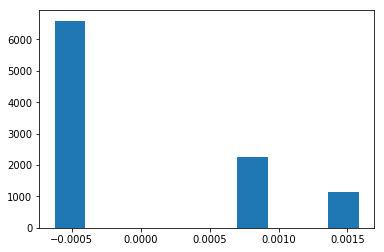

In [94]:
    
Ltest = 10**4

        
xtest=([100*np.ones(Ltest)]+[np.zeros(Ltest)]+[0.3*np.random.binomial(1, 1/3, Ltest)+0.9 for i in range(N)])
plt.hist(hedging_train.predict(xtest))
plt.show()


In [95]:
weights = hedging_train.get_weights()


In [100]:
# This is to compute the precise values of the Hedgingstrategies
# This only works if the number of layers are $d$ and $N=2$.

H1helper=np.tanh(100*(weights[0])+weights[1])
H1=0
for k in range(n):
    H1=H1+weights[2][k]*H1helper[0][k]
H1=H1+weights[3]    

print('Deep Hedging finds for H1', H1, 'versus the true values of', 26/45.)


H2helperup=np.tanh(120*(weights[4])+weights[5])
H2up=0
for k in range(n):
    H2up=H2up+weights[6][k]*H2helperup[0][k]
H2up=H2up+weights[7] 

print('Deep Hedging finds for H2 in the upper scenario ', H2up, 'versus the true values of', 1)

H2helperdown=np.tanh(90*(weights[4])+weights[5])
H2down=0
for k in range(n):
    H2down=H2down+weights[6][k]*H2helperdown[0][k]
H2down=H2down+weights[7] 

print('Deep Hedging finds for H2 in the upper scenario ', H2down, 'versus the true values of', 8/27)



Deep Hedging finds for H1 [0.577766] versus the true values of 0.5777777777777777
Deep Hedging finds for H2 in the upper scenario  [0.99994373] versus the true values of 1
Deep Hedging finds for H2 in the upper scenario  [0.29623994] versus the true values of 0.2962962962962963
